In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn import metrics
import pmdarima as pm
import statsmodels.api as sm

In [74]:
def query(parametro):
    query = f'''
        SELECT 
            {parametro} Periodo,
            sum(Cantidad) almuerzos

        FROM 
            (
                SELECT
                    Dia_del_Año,
                    Numero_de_Mes,
                    Numero_de_Semana,
                    Año,
                    id_cliente,
                    Boleta,
                    id_producto,
                    Cantidad,
                    Total,
                    Fecha
                FROM ingresos
                WHERE 1=1
                    AND Año >= 2023
                    AND Tipo LIKE "ALMUERZOS"
            ) as sub
        GROUP BY 1
    '''
    return query

def prueba_dickey_fuller(serie_temporal):
    print("Resultados de la prueba de Dickey-Fuller")
    # print(serie_temporal.head(5))
    dftest = adfuller(serie_temporal, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags Used', 'N° observaciones'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusión:')
        print('Rechazar H0 - Los datos son estacionarios')
    else:
        print('Conclusión:')
        print('No rechazar H0 - Los datos no son estacionarios')


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100        

def evaluacion_metrica(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [75]:
load_dotenv()

url = f"mysql+mysqlconnector://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
engine = create_engine(url=url)

df = pd.read_sql(query('Fecha'), con=engine)

df['Periodo'] = pd.to_datetime(df['Periodo'])
df = df.rename(columns={'Periodo':'Fecha'})
df = df.dropna()

df = df[df['Fecha'] >= '2023-03-01']

rango_completo = pd.date_range(start=df['Fecha'].iloc[0], end=df['Fecha'].iloc[-1], freq='D')
fechas_faltantes = set(rango_completo) - set(df['Fecha'])
df_faltantes = pd.DataFrame({'Fecha': list(fechas_faltantes), 'almuerzos':0})

df = pd.concat([df, df_faltantes]).sort_values('Fecha').reset_index(drop=True)
df = df.sort_values('Fecha')
df = df.set_index('Fecha')

# df.index.freq = 'D'

df

,almuerzos
Fecha,
2023-03-01,8.0
2023-03-02,7.0
2023-03-03,5.0
2023-03-04,6.0
2023-03-05,12.0
...,...
2024-02-08,10.0
2024-02-09,2.0
2024-02-10,14.0


In [76]:
prueba_dickey_fuller(df['almuerzos'])

Resultados de la prueba de Dickey-Fuller
Test Statistic           -2.489869
p-value                   0.117959
No Lags Used             13.000000
N° observaciones        335.000000
Critical Value (1%)      -3.450022
Critical Value (5%)      -2.870207
Critical Value (10%)     -2.571387
dtype: float64
Conclusión:
No rechazar H0 - Los datos no son estacionarios


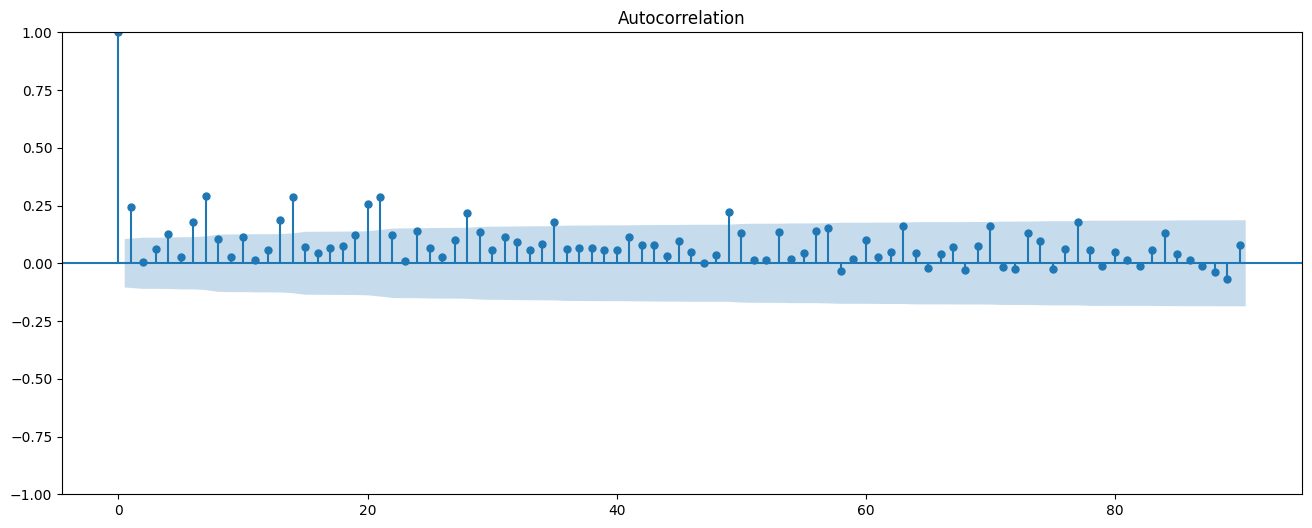

In [77]:
# def grafico_correlacion():
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    # plot_acf(df['almuerzos'], ax=ax1, lags=50)
    # plot_pacf(df['almuerzos'], ax=ax2, lags=50)
    # plt.tight_layout()

fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(df['almuerzos'], ax=ax, lags=90)
plt.show()

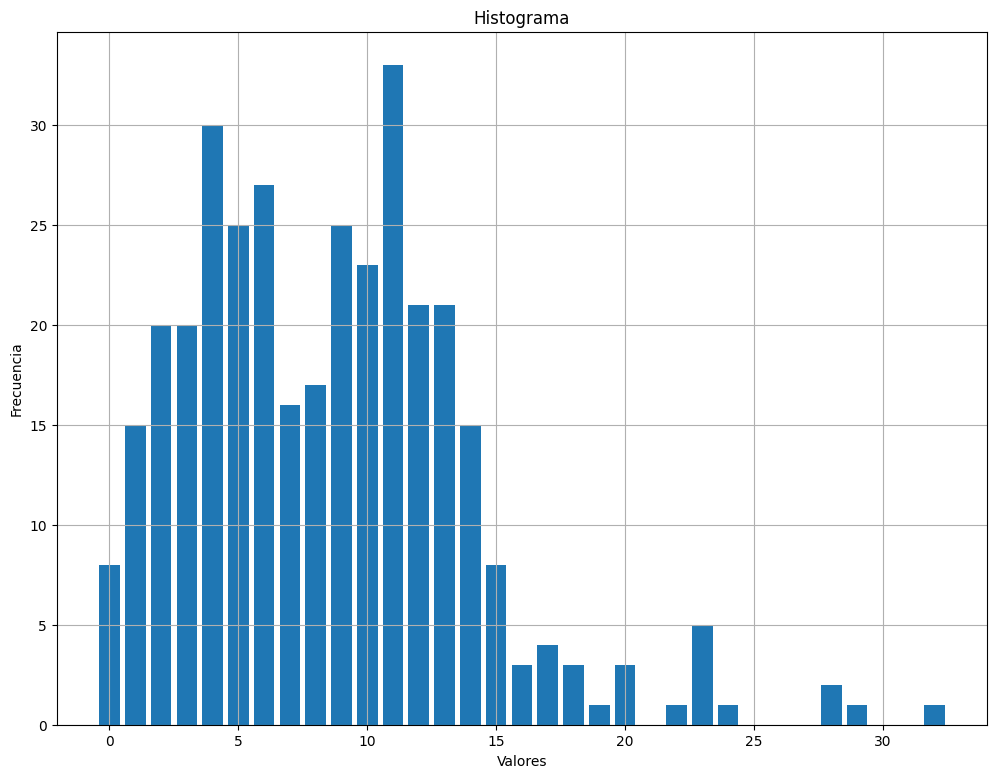

,almuerzos,count
14,0.0,8
12,1.0,15
8,2.0,20
9,3.0,20
1,4.0,30
3,5.0,25
2,6.0,27
11,7.0,16
10,8.0,17
4,9.0,25


In [78]:
dist = df.almuerzos.value_counts()
dist = pd.DataFrame(dist).reset_index()
# dist = dist['almuerzos'].sort_values()
dist = dist.sort_values('almuerzos', ascending=True)

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(dist['almuerzos'], height=dist['count'])

# Personalizar el gráfico
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el gráfico
plt.show()

dist

In [79]:
train_data = df[(df.index<'2024-01-01')]
test_data = df[(df.index>='2024-01-01')]

train_data.shape, test_data.shape

((306, 1), (43, 1))

# ARIMA Semanal

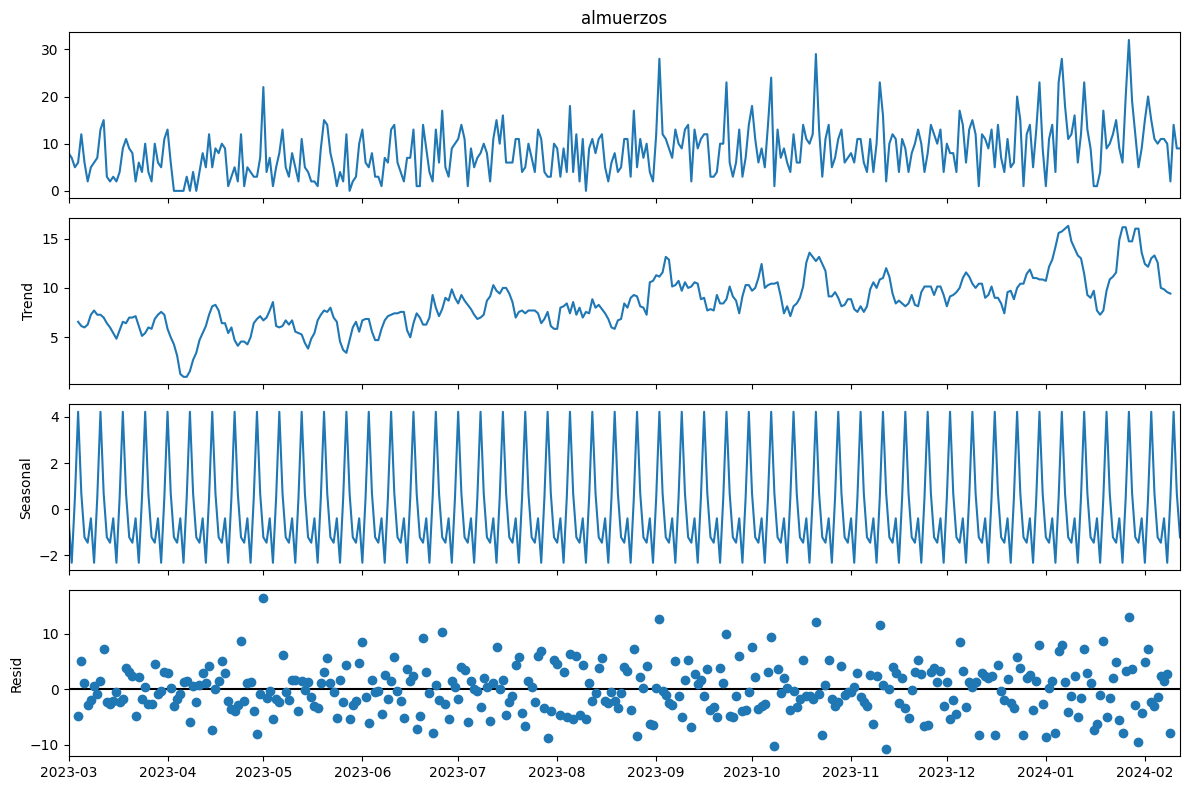

In [81]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df["almuerzos"], model = "add", period=7)
a.plot();

In [82]:
# Modelo Auto-Arima Semanal
modelo_auto_semanal = pm.auto_arima(train_data['almuerzos'], 
                       start_p=0, d=2, start_q=1,
                       max_p=3, max_q=3,  # Reducido el rango de búsqueda
                       start_P=0, D=0, start_Q=0, 
                       max_P=2, max_D=2, max_Q=2,  # Reducido el rango de búsqueda
                       m=7, seasonal=True, 
                       error_action='warn', trace=True,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=30, 
                       n_fits=50)

print(modelo_auto_semanal)

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2314.333, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2176.375, Time=0.17 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=2187.881, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=2175.873, Time=0.23 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=2162.148, Time=0.75 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=2161.375, Time=0.39 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=2178.494, Time=0.13 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=2162.074, Time=0.80 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=2178.355, Time=0.26 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=2162.448, Time=0.91 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=2301.462, Time=0.27 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=2088.549, Time=0.59 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=2

In [ ]:
print(modelo_auto_semanal.summary())

In [83]:
modelo_arima_semanal = sm.tsa.SARIMAX(train_data['almuerzos'], order=(2,2,0), seasonal_order=(1,0,1,7))
resultado_arima_semanal = modelo_arima_semanal.fit()
print(resultado_arima_semanal.summary())

c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                           almuerzos   No. Observations:                  306
Model:             SARIMAX(2, 2, 0)x(1, 0, [1], 7)   Log Likelihood               -1039.275
Date:                             Tue, 13 Feb 2024   AIC                           2088.549
Time:                                     00:14:02   BIC                           2107.135
Sample:                                 03-01-2023   HQIC                          2095.984
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9042      0.046    -19.472      0.000      -0.995      -0.813
ar.L2         -0.4700      

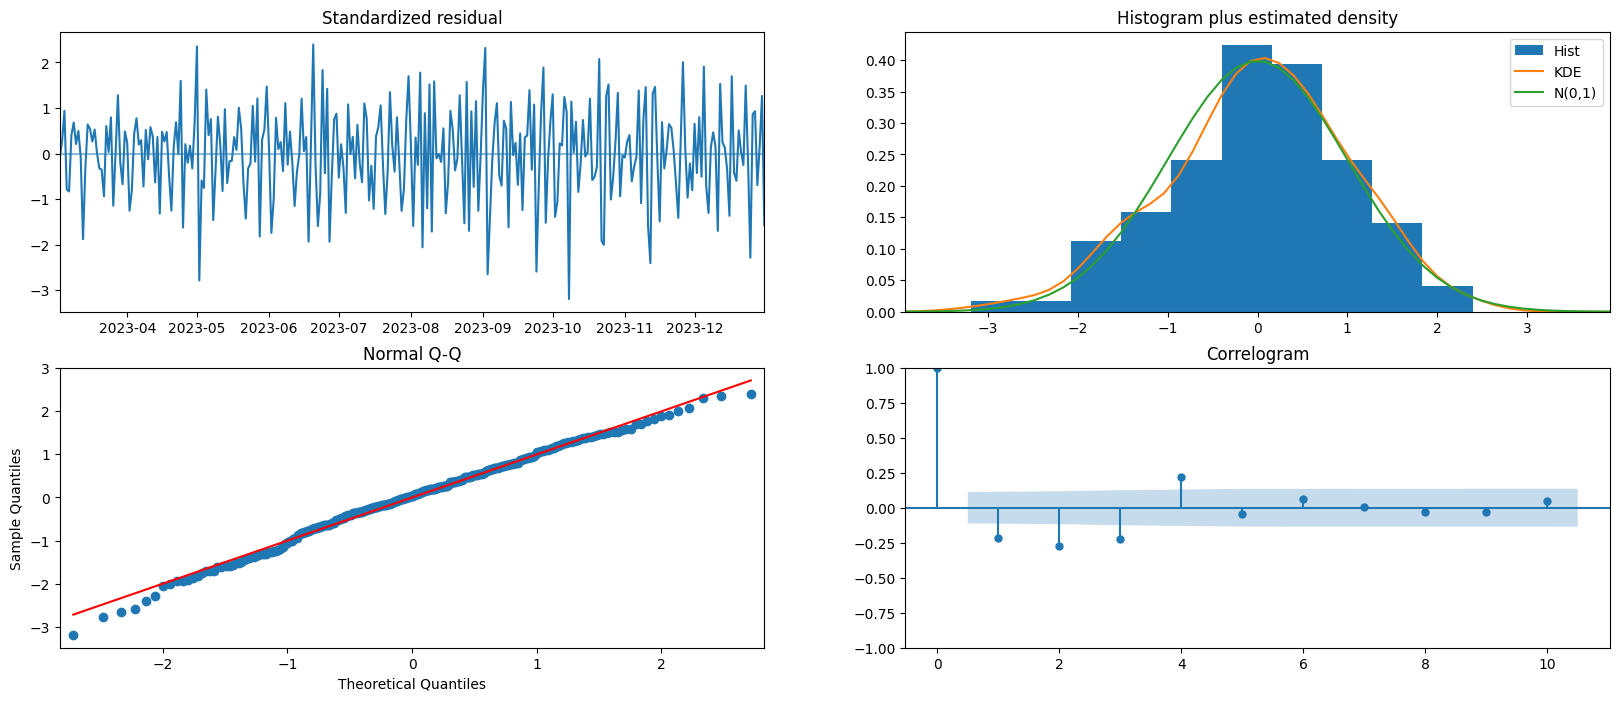

In [84]:
# plt.style.use('seaborn')
modelo_auto_semanal.plot_diagnostics(figsize=(20,8))
plt.show()

In [90]:
pred_semanal = resultado_arima_semanal.predict(start=len(train_data), end=348).rename('ARIMA Semanal')
pred_semanal

2024-01-01    11.461795
2024-01-02    12.282354
2024-01-03     9.806906
2024-01-04     8.492540
2024-01-05     9.381976
2024-01-06    11.198174
2024-01-07     7.807333
2024-01-08     4.467350
2024-01-09     5.457460
2024-01-10     5.412083
2024-01-11     1.723890
2024-01-12     3.490248
2024-01-13     5.439837
2024-01-14     1.386517
2024-01-15    -1.471465
2024-01-16    -0.694609
2024-01-17    -0.914356
2024-01-18    -4.439871
2024-01-19    -2.863777
2024-01-20    -1.004545
2024-01-21    -5.014183
2024-01-22    -7.922535
2024-01-23    -7.207858
2024-01-24    -7.485866
2024-01-25   -11.022984
2024-01-26    -9.531905
2024-01-27    -7.772966
2024-01-28   -11.777122
2024-01-29   -14.695681
2024-01-30   -14.059987
2024-01-31   -14.397470
2024-02-01   -17.935524
2024-02-02   -16.536337
2024-02-03   -14.873223
2024-02-04   -18.870470
2024-02-05   -21.801690
2024-02-06   -21.241899
2024-02-07   -21.638063
2024-02-08   -25.177579
2024-02-09   -23.868026
2024-02-10   -22.299326
2024-02-11   -26

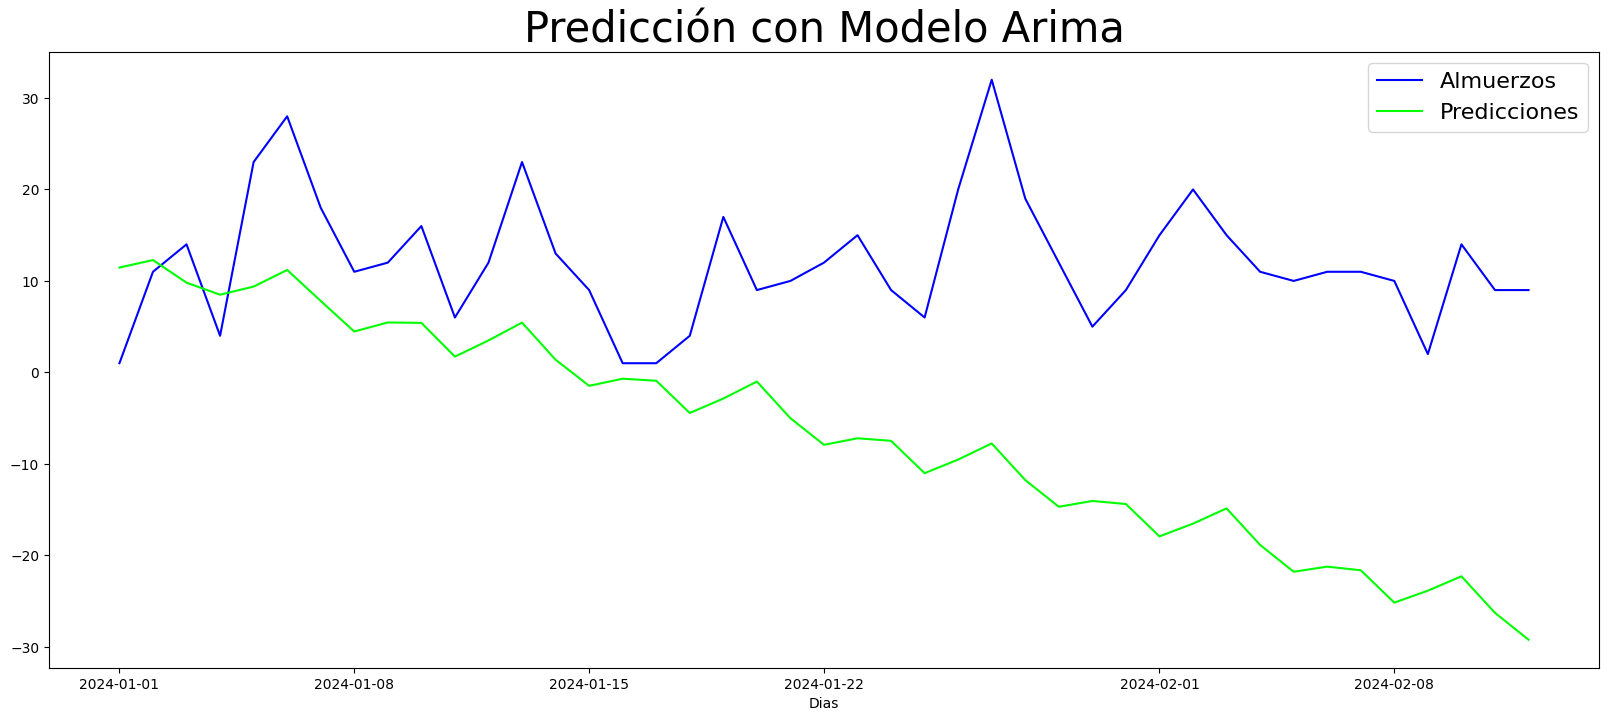

In [91]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_semanal, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [93]:
evaluacion_metrica(test_data['almuerzos'], pred_semanal)

Evaluation metric results:-
MSE is : 513.6668648483542
MAE is : 19.435054308035543
RMSE is : 22.66421992587334
MAPE is : 221.18589478394867
R2 is : -10.207519507040105



In [94]:
test_data['ARIMA_SEMANAL'] = pred_semanal.copy()

C:\Users\felip\AppData\Local\Temp\ipykernel_21684\1565297025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA_SEMANAL'] = pred_semanal.copy()


# ARIMA Mensual

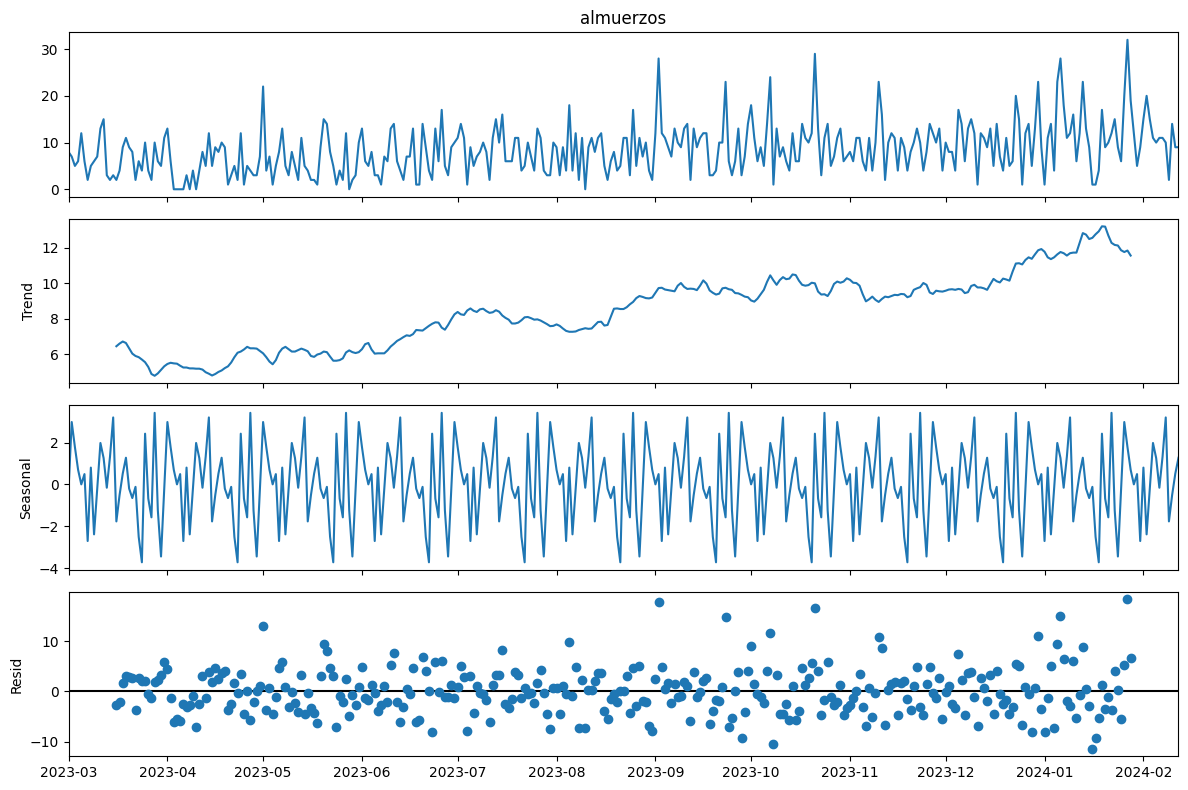

In [95]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df["almuerzos"], model = "add", period=30)
a.plot();

In [96]:
# Modelo Auto-Arima Mensual
modelo_auto_mensual = pm.auto_arima(train_data['almuerzos'], 
                       start_p=0, d=1, start_q=0, 
                       max_p=2, max_q=2,  # Reducido el rango de búsqueda
                       start_P=0, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1,  # Reducido el rango de búsqueda
                       m=30, seasonal=True, 
                       error_action='warn', trace=True,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=20, 
                       n_fits=50)

print(modelo_auto_mensual)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=2019.219, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=1879.514, Time=1.48 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=7.35 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=1976.473, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=12.59 sec
 ARIMA(1,1,0)(0,1,1)[30]             : AIC=inf, Time=8.71 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=1924.120, Time=1.18 sec
 ARIMA(2,1,0)(1,1,0)[30]             : AIC=1862.194, Time=2.11 sec
 ARIMA(2,1,0)(0,1,0)[30]             : AIC=1938.821, Time=0.39 sec
 ARIMA(2,1,0)(1,1,1)[30]             : AIC=inf, Time=17.91 sec
 ARIMA(2,1,0)(0,1,1)[30]             : AIC=inf, Time=10.62 sec
 ARIMA(2,1,1)(1,1,0)[30]             : AIC=inf, Time=16.53 sec
 ARIMA(1,1,1)(1,1,0)[30]             : AIC=inf, Time=10.59 sec
 ARIMA(2,1,0)(1,1,0)[30] intercept   : AIC=1864.193, Time=6.45 sec

Best model:  ARIMA(2,1,0)(1,1,0)[30]          
T

In [ ]:
print(modelo_auto_mensual.summary())

In [97]:
modelo_arima_mensual = sm.tsa.SARIMAX(train_data['almuerzos'], order=(2,1,0), seasonal_order=(1,1,0,30))
resultado_arima_mensual = modelo_arima_mensual.fit()
print(resultado_arima_mensual.summary())

c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          almuerzos   No. Observations:                  306
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 30)   Log Likelihood                -927.097
Date:                            Tue, 13 Feb 2024   AIC                           1862.194
Time:                                    00:20:05   BIC                           1876.661
Sample:                                03-01-2023   HQIC                          1868.000
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5000      0.052     -9.586      0.000      -0.602      -0.398
ar.L2         -0.2696      0.064   

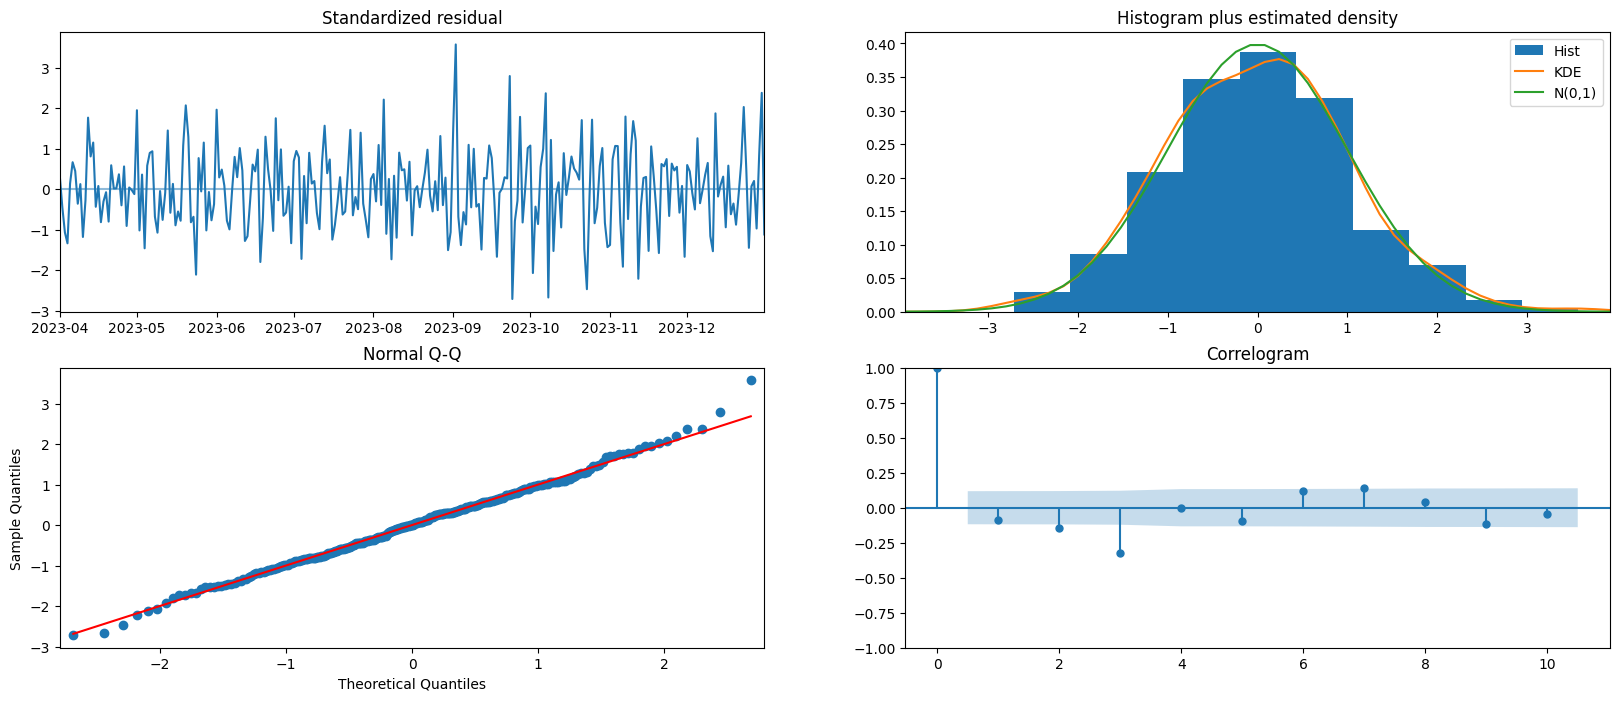

In [98]:
modelo_auto_mensual.plot_diagnostics(figsize=(20,8))
plt.show()

In [100]:
pred_mensual = resultado_arima_mensual.predict(start=len(train_data), end=len(df)-1, typ='levels')
pred_mensual

c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2024-01-01    11.979223
2024-01-02    16.783506
2024-01-03    12.422480
2024-01-04    16.680147
2024-01-05    14.545502
2024-01-06    14.012446
2024-01-07    13.802240
2024-01-08    17.937756
2024-01-09    23.219431
2024-01-10    14.311213
2024-01-11    12.304814
2024-01-12    15.983432
2024-01-13    16.066869
2024-01-14    17.465190
2024-01-15     9.984858
2024-01-16    17.943824
2024-01-17    13.546908
2024-01-18     9.505622
2024-01-19    14.943895
2024-01-20    13.108564
2024-01-21    15.149707
2024-01-22    20.299845
2024-01-23    14.779269
2024-01-24    10.149710
2024-01-25    18.546809
2024-01-26    18.464489
2024-01-27    13.108550
2024-01-28    18.505649
2024-01-29    18.614625
2024-01-30    15.026229
2024-01-31    15.413367
2024-02-01    17.716636
2024-02-02    13.543553
2024-02-03    22.352305
2024-02-04    19.767174
2024-02-05    15.346974
2024-02-06    18.890259
2024-02-07    21.914067
2024-02-08    22.884466
2024-02-09    12.887308
2024-02-10    17.651783
2024-02-11    18

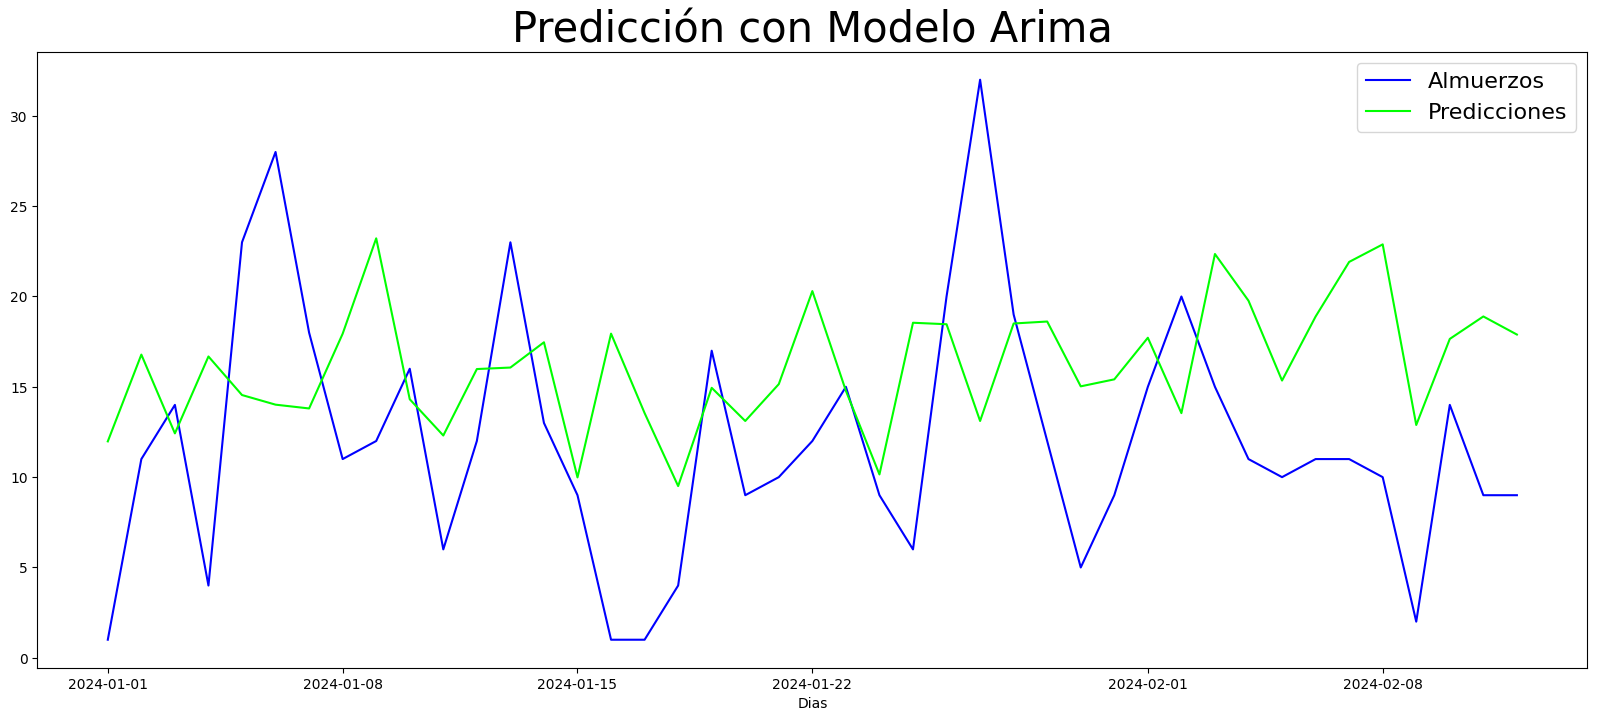

In [101]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_mensual, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [102]:
test_data.loc[:,'ARIMA_MENSUAL'] = pred_mensual.copy()

C:\Users\felip\AppData\Local\Temp\ipykernel_21684\3461265054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:,'ARIMA_MENSUAL'] = pred_mensual.copy()


In [103]:
evaluacion_metrica(test_data['almuerzos'], pred_mensual)

Evaluation metric results:-
MSE is : 71.2404857128607
MAE is : 7.170624067464731
RMSE is : 8.44040791152067
MAPE is : 166.64936498327097
R2 is : -0.5543714963074604



# Evaluación Trimestral

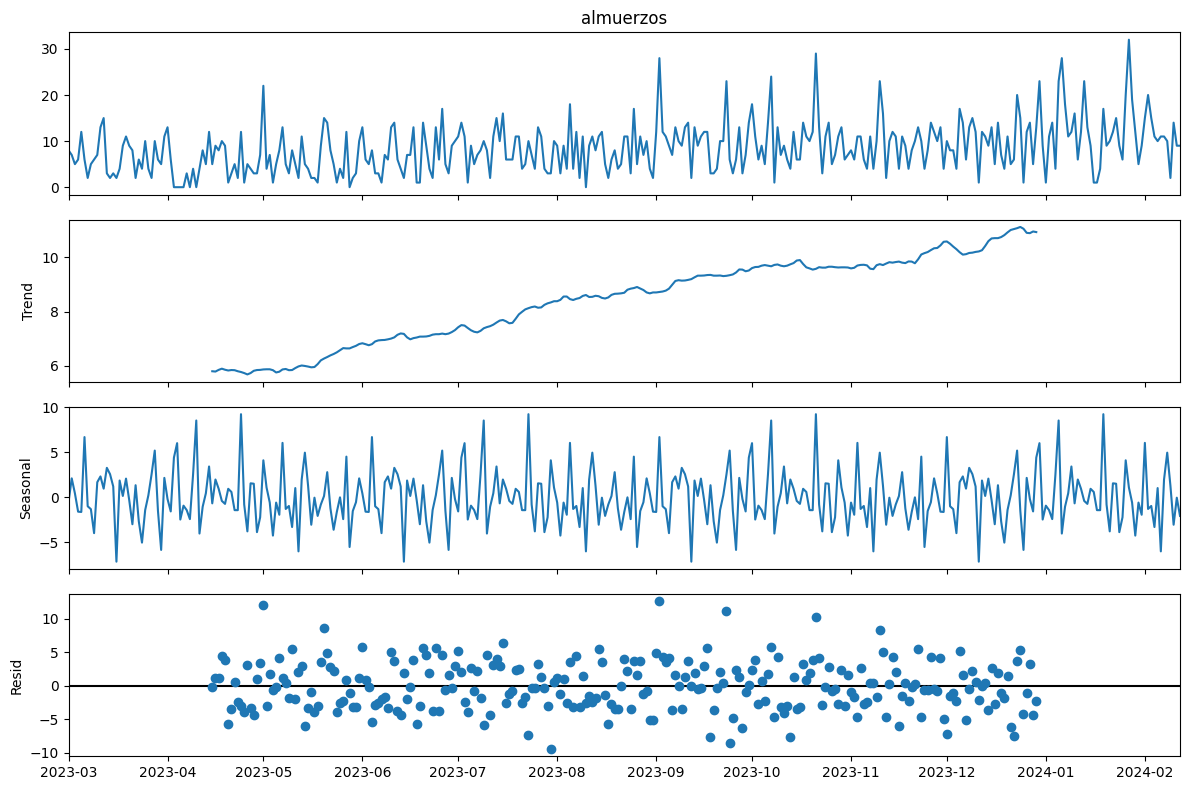

In [104]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df["almuerzos"], model = "add", period=90)
a.plot();


In [105]:
modelo_auto_trimestral = pm.auto_arima(train_data['almuerzos'], 
                       start_p=0, d=1, start_q=0, 
                       max_p=2, max_q=2,  # Reducido el rango de búsqueda
                       start_P=0, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1,  # Reducido el rango de búsqueda
                       m=90, seasonal=True, 
                       error_action='warn', trace=False,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=20, 
                       n_fits=50)

print(modelo_auto_trimestral)

KeyboardInterrupt: 

In [106]:
modelo_arima_trimestral = sm.tsa.SARIMAX(train_data['almuerzos'], order=(1,1,0), seasonal_order=(1,1,1,90))
resultado_arima_trimestral = modelo_arima_trimestral.fit()
print(resultado_arima_trimestral.summary())

c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                            almuerzos   No. Observations:                  306
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 90)   Log Likelihood                -730.237
Date:                              Tue, 13 Feb 2024   AIC                           1468.474
Time:                                      00:34:18   BIC                           1481.957
Sample:                                  03-01-2023   HQIC                          1473.922
                                       - 12-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3896      0.065     -5.952      0.000      -0.518      -0.261
ar.S.L90      -0.03

In [109]:

modelo_arima_trimestral.plot_diagnostics(figsize=(20,8))
plt.show()

AttributeError: 'SARIMAX' object has no attribute 'plot_diagnostics'

In [110]:
pred_trimestral = resultado_arima_trimestral.predict(start=len(train_data), end=len(df)-1, typ='levels')
pred_trimestral

c:\Users\felip\OneDrive\Desktop\Casa\Software\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2024-01-01    13.397763
2024-01-02    12.694529
2024-01-03    11.610947
2024-01-04    15.984236
2024-01-05    18.681105
2024-01-06    11.831954
2024-01-07    14.921785
2024-01-08    15.154066
2024-01-09    19.489960
2024-01-10    14.481794
2024-01-11    17.245567
2024-01-12    15.997506
2024-01-13    14.713608
2024-01-14    14.386924
2024-01-15    16.108707
2024-01-16    15.793431
2024-01-17    13.670846
2024-01-18    13.687059
2024-01-19    24.194894
2024-01-20    14.384119
2024-01-21    11.410701
2024-01-22    16.820970
2024-01-23    16.762060
2024-01-24    11.403108
2024-01-25    13.005150
2024-01-26    19.196818
2024-01-27    16.415450
2024-01-28    14.784850
2024-01-29    11.045096
2024-01-30    14.777238
2024-01-31    13.359420
2024-02-01    21.513207
2024-02-02    13.993783
2024-02-03    14.529427
2024-02-04    12.012781
2024-02-05    16.446735
2024-02-06     9.351848
2024-02-07    17.383082
2024-02-08    20.321353
2024-02-09    16.683195
2024-02-10    12.560848
2024-02-11    15

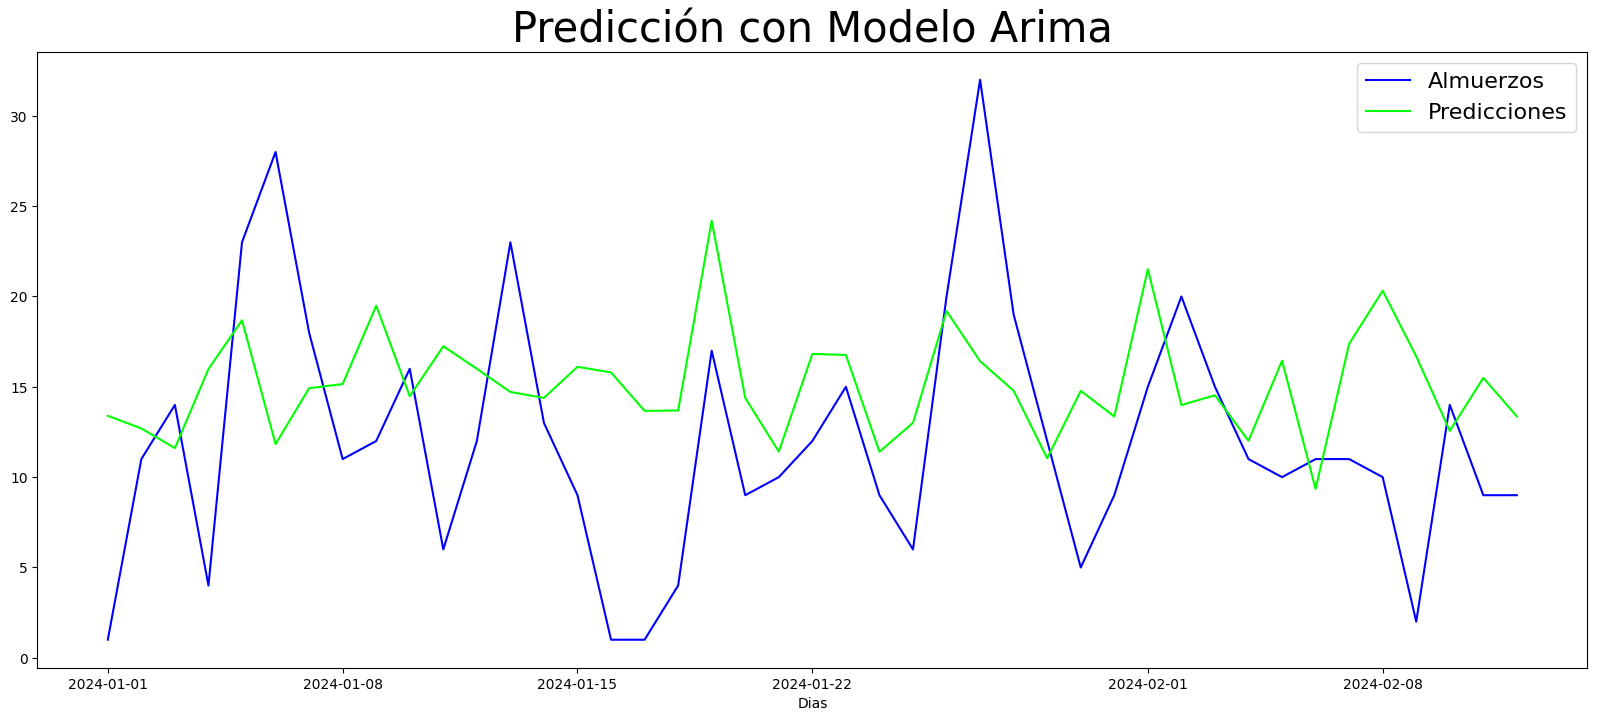

In [111]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_trimestral, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [112]:
test_data.loc[:, 'ARIMA_TRIMESTRAL'] = pred_trimestral.copy()

C:\Users\felip\AppData\Local\Temp\ipykernel_21684\1044408594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'ARIMA_TRIMESTRAL'] = pred_trimestral.copy()


In [113]:
evaluacion_metrica(test_data['almuerzos'], pred_trimestral)

Evaluation metric results:-
MSE is : 58.11140502920971
MAE is : 6.18195192818574
RMSE is : 7.623083695540126
MAPE is : 161.3994221041319
R2 is : -0.26791262979100283



In [114]:
test_data.to_csv('resultados_arima.csv')

In [ ]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_semanal, color="lime", label="Predicciones Sem")
plt.plot(pred_mensual, color="red", label="Predicciones Men")
plt.plot(pred_trimestral, color="black", label="Predicciones Tri")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();